In [1]:
# Initialize these:
typeImg = "test" # photo/ cartoon/ top"
#numImg = "50" # 5 or 50
sz = 100
numColors = 37

In [2]:
# # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import time

In [3]:
colNames = ["col_"+str(i) for i in range(numColors)] 
allConcepts = ["Paper", "Plastic", "Trash", "Compost", "Metal","Glass"]

# # Read data
# # Get the color ratings data -From file data_clean.csv
data = pd.read_csv("TestScripts/data_clean_test.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
# # #colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("TestScripts/Lab_test.csv",header=None)
colorDataRGB = pd.read_csv("TestScripts/RGB_test.csv",header=None)

category = pd.read_csv("TestScripts/Category_test.csv",header=None)
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
# if not os.path.exists( path + "/trainResized" ):
#    os.makedirs( path + "/trainResized/" )


In [4]:
data

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36
0,0.13510,0.30566,0.25250,0.20077,0.21622,0.45617,0.38230,0.24153,0.29612,0.51005,...,0.25852,0.16832,0.34235,0.26056,0.14352,0.162450,0.43541,0.73454,0.94781,0.99816
1,0.25500,0.28179,0.25704,0.20066,0.28949,0.32163,0.28429,0.15857,0.32000,0.33602,...,0.38342,0.25633,0.27168,0.24730,0.21372,0.303670,0.53347,0.72061,0.77847,0.78633
2,0.13031,0.21107,0.23602,0.37719,0.25760,0.28020,0.40837,0.75372,0.22796,0.31219,...,0.32526,0.10612,0.14628,0.19806,0.18719,0.745410,0.74628,0.67842,0.45653,0.29219
3,0.10582,0.22423,0.29704,0.35684,0.26128,0.35179,0.52622,0.82592,0.30607,0.32730,...,0.29531,0.11332,0.13485,0.14832,0.18597,0.498110,0.59270,0.58827,0.37031,0.30015
4,0.11036,0.15791,0.18842,0.28520,0.15138,0.14964,0.22046,0.38776,0.16041,0.21454,...,0.32449,0.11245,0.11653,0.13684,0.12036,0.659640,0.94730,0.91128,0.65408,0.42536
5,0.11704,0.18582,0.21806,0.15286,0.16092,0.28347,0.28434,0.13255,0.19444,0.33439,...,0.47577,0.12173,0.30408,0.21148,0.12449,0.095255,0.44714,0.65577,0.79760,0.73745


In [5]:
# Count total number of images
count = 0
for i in allConcepts:
    print(path + "/" +typeImg +"/" +i+"/*.*")
    trainFiles = glob.glob( path + "/" +typeImg +"/" +i+"/*.*" )
    count = count + len(trainFiles[:50])
    #print(count)
print("Category: ",typeImg)
print("Total images : ",count)

E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Paper/*.*
E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Plastic/*.*
E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Trash/*.*
E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Compost/*.*
E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Metal/*.*
E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/test/Glass/*.*
Category:  test
Total images :  300


In [6]:
import matlab.engine
def getCategoriesMatrix(imageFileName,sz):
    ## Get total pixel counts of all 11 categories for this imageFile
    eng = matlab.engine.start_matlab()
    imageCat = np.array(eng.getCategories(imageFileName,sz))
    eng.quit()
     # imageCat : sz x sz matrix where each pixel has its category
    return imageCat

def getSegmentedImage(imageFileName,sz): # Returns segmented pixels in LAB and its corresponding color category.
    eng = matlab.engine.start_matlab()
    segImg, segImgCat = eng.activeContourSegmentation(imageFileName,sz, nargout=2)
    eng.quit()
    segImg = np.array(segImg)/255;
    segImg = skcolor.rgb2lab(segImg)
    segImgCat = np.array(segImgCat)
    return segImg, segImgCat


In [7]:
numFt = 3
X = np.zeros((count*numColors,numFt+1) )  # +1 for label #Number of features [] # Feature Vector -- 58N rows
init = time.time()
rowNum = -1
strtInd = []  # To keep track of the starting indices of fruits in the feature matrix
cvInd = 1 
counter = 0
sz = 100    # Size of image: 100 by 100
# ########
# allConcepts = ['Glass']
# rowNum = 9249
# counter = 9249

# ##
Rc = [1,10,20,30,40]   # Radii thresholds
Li = [40]              #[1, 10, 20, 30, 40]
R = [40]               #[1, 10, 20, 30, 40]     # same as L
hueAngle = [40]        #[5, 10, 20, 30, 40] # Hue Angle
##
for conceptNum,concept in enumerate(allConcepts):
    #conceptNum = 5
    t0 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>\n",conceptNum+1,": Concept : ",concept)
    # Get label for corresponding fruit (for given color)
    #label = data.loc[conceptNum]['col_'+str(color)]
    ct = 0    # Keeps track of images inside a category
    strtInd.append(counter)
    trainFiles = glob.glob( path + "/" +typeImg +"/" +concept+"/*.*" )
    print("\tTotal number of images for ",concept," : ",len(trainFiles))
    t = []
    for m, nameFile in enumerate(trainFiles[:50]):
        t1 = time.time()
        #print("\nReading file ......")
        ct = ct + 1
        
        image = imread( nameFile )
        imageResized = resize( image, (sz,sz),anti_aliasing=True,mode='reflect')
        img = imageResized
        # Convert the pixels in  image to LAB space
        imgLAB = skcolor.rgb2lab(img)
        segmentedImg,segmentedImgCat = getSegmentedImage(nameFile,sz)
        imageWithCategories = getCategoriesMatrix(nameFile,sz)
        
        i1 = imgLAB[27:72,27:72,:] 
#         i2 = imgLAB[19:83,19:83,:]
#         i3 = imgLAB[12:90,12:90,:]
#         i4 = imgLAB[6:96,6:96,:]
#         i5 = np.copy(imgLAB)
        i6 = np.copy(segmentedImg)
        
        ii1 = imageWithCategories[27:72,27:72].flatten()
#         ii2 = imageWithCategories[19:83,19:83].flatten()
#         ii3 = imageWithCategories[12:90,12:90].flatten()
#         ii4 = imageWithCategories[6:96,6:96].flatten()
#         ii5 = np.copy(imageWithCategories).flatten()
#         ii6 = np.copy(segmentedImgCat).flatten()
        
        categoryImg1 = [sum(1 for p in ii1 if p-1 == k)/ii1.size for k in range(11)]
#         categoryImg2 = [sum(1 for p in ii2 if p-1 == k)/ii2.size for k in range(11)]
#         categoryImg3 = [sum(1 for p in ii3 if p-1 == k)/ii3.size for k in range(11)]
#         categoryImg4 = [sum(1 for p in ii4 if p-1 == k)/ii4.size for k in range(11)]
#         categoryImg5 = [sum(1 for p in ii5 if p-1 == k)/ii5.size for k in range(11)]
#         categoryImg6 = [sum(1 for p in ii6 if p-1 == k)/ii6.size for k in range(11)]
        
        
        for color in range(numColors):
            rowNum+=1
            counter += 1
            colCt = 0
            # Thus begin the long long process
            # Get spherical and add till 
            colorLAB = np.array(colorData.loc[color])   #get LAB values for specific color
            
#             ##   Columns 1-30
#             for i in range(6):
#                 if i == 0:
#                     distPixel = skcolor.deltaE_cie76(i1,colorLAB)
#                 elif i == 1:
#                     distPixel = skcolor.deltaE_cie76(i2,colorLAB)
#                 elif i == 2:
#                     distPixel = skcolor.deltaE_cie76(i3,colorLAB)
#                 elif i == 3:
#                     distPixel = skcolor.deltaE_cie76(i4,colorLAB)
#                 elif i == 4:
#                     distPixel = skcolor.deltaE_cie76(i5,colorLAB)
#                 else:
#                     distPixel = skcolor.deltaE_cie76(i6,colorLAB)
#                 distPixel = distPixel.flatten()
#                 #print(distPixel.size)
#                 for j,threshold in enumerate(Rc):
#                     num = sum(1 for t in distPixel  if t <= threshold)/distPixel.size
#                     #features.append(num)
#                     X[rowNum,colCt] = num
                    
#                     colCt+=1
            #print(colCt)
            
            # For features 31-180
            #for i in range(6):
            for i in [0,5]:
                if i == 0:
                    L = i1[:,:,0]
                    a = i1[:,:,1]
                    b = i1[:,:,2]
                elif i == 1:
                    L = i2[:,:,0]
                    a = i2[:,:,1]
                    b = i2[:,:,2]
                elif i == 2:
                    L = i3[:,:,0]
                    a = i3[:,:,1]
                    b = i3[:,:,2]
                elif i == 3:
                    L = i4[:,:,0]
                    a = i4[:,:,1]
                    b = i4[:,:,2]
                elif i == 4:
                    L = i5[:,:,0]
                    a = i5[:,:,1]
                    b = i5[:,:,2]
                else:
                    L = i6[:,:,0]
                    a = i6[:,:,1]
                    b = i6[:,:,2]
                    
                LTemp = L.flatten()
                r = np.sqrt(a**2+b**2).flatten()
                theta = np.degrees(np.arctan2(b,a)).flatten()

                L_diff = np.abs(LTemp - colorLAB[0])
                r_diff = np.abs(r - (np.sqrt(colorLAB[1]**2 + colorLAB[2]**2)))
                theta_diff = np.abs(theta - np.degrees(np.arctan2(colorLAB[2],colorLAB[1])))

                for j,r_th in enumerate(R):
                    l_th = Li[j] # L and R are the same.
                    for theta_th in hueAngle:
                        pixels = 0
                        for p in range(len(L_diff)):
                            if (L_diff[p] <= l_th and r_diff[p] <= r_th and theta_diff[p] <= theta_th) or (L_diff[p] <= l_th and r_diff[p] <= 2.5):
                                pixels += 1
                        X[rowNum,colCt] = pixels/(len(L_diff))
                        colCt+=1
            #print(colCt)
            
            colorCat = category.loc[color,0] 
            X[rowNum,colCt] = categoryImg1[colorCat-1]
            colCt+=1
            #print(colCt)

#             X[rowNum,colCt] = categoryImg2[colorCat-1]
#             colCt+=1
#             X[rowNum,colCt] = categoryImg3[colorCat-1]
#             colCt+=1
#             X[rowNum,colCt] = categoryImg4[colorCat-1]
#             colCt+=1
#             X[rowNum,colCt] = categoryImg5[colorCat-1]
#             colCt+=1
#             X[rowNum,colCt] = categoryImg6[colorCat-1]
#             colCt+=1
            label = data.loc[conceptNum]['col_'+str(color)]   
            X[rowNum,colCt] = label
            #print(colCt)
        h = time.time()-t1
        print("\t\t",m, "image: ",h ," seconds")
        t.append(h)
    print(t)
    print("\t** Time elapsed since last category: ",time.time()-t0," seconds **")
strtInd.append(len(X))
print(strtInd)
print("** Total Time elapsed: ",time.time()-init," seconds **")

>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 1 : Concept :  Paper
	Total number of images for  Paper  :  73
		 0 image:  21.30913543701172  seconds
		 1 image:  20.406524896621704  seconds
		 2 image:  25.95879054069519  seconds
		 3 image:  35.05331373214722  seconds
		 4 image:  71.00841069221497  seconds
		 5 image:  25.509149074554443  seconds
		 6 image:  31.430436849594116  seconds
		 7 image:  41.54574418067932  seconds
		 8 image:  33.11904335021973  seconds
		 9 image:  47.50077486038208  seconds
		 10 image:  32.64933466911316  seconds
		 11 image:  35.20961308479309  seconds
		 12 image:  34.60273599624634  seconds
		 13 image:  34.85100293159485  seconds
		 14 image:  34.42896747589111  seconds
		 15 image:  35.64798402786255  seconds
		 16 image:  28.45499277114868  seconds
		 17 image:  27.974184036254883  seconds
		 18 image:  33.79410719871521  seconds
		 19 image:  33.63206219673157  seconds
		 20 image:  28.842003107070923  seconds
		 21 image:  32.81006574630737  seconds
		 22 imag

		 41 image:  20.604933500289917  seconds
		 42 image:  19.09097909927368  seconds
		 43 image:  19.491908311843872  seconds
		 44 image:  21.74089789390564  seconds
		 45 image:  32.19296455383301  seconds
		 46 image:  19.639512300491333  seconds
		 47 image:  19.162786960601807  seconds
		 48 image:  21.054732084274292  seconds
		 49 image:  19.513850450515747  seconds
[19.27149724960327, 19.51684260368347, 19.05208420753479, 19.346297025680542, 19.729273796081543, 19.64849042892456, 18.6062753200531, 18.966312408447266, 19.924752235412598, 30.114516496658325, 33.269089460372925, 19.4729585647583, 19.475951194763184, 19.785130262374878, 20.032458543777466, 44.25772190093994, 24.934365034103394, 24.03576350212097, 25.664413452148438, 21.413772106170654, 22.495879888534546, 19.38519310951233, 19.812053442001343, 26.914092779159546, 29.34357786178589, 19.39417004585266, 19.09097957611084, 19.76916813850403, 21.02880072593689, 19.335327863693237, 19.520830631256104, 29.052358388900757, 

		 7 image:  25.959623098373413  seconds
		 8 image:  20.131199598312378  seconds
		 9 image:  24.085155248641968  seconds
		 10 image:  24.214382886886597  seconds
		 11 image:  22.41763663291931  seconds
		 12 image:  23.414409399032593  seconds
		 13 image:  21.333019971847534  seconds
		 14 image:  33.13380718231201  seconds
		 15 image:  22.469554901123047  seconds
		 16 image:  21.94250464439392  seconds
		 17 image:  22.085199117660522  seconds
		 18 image:  23.04300808906555  seconds
		 19 image:  25.795879125595093  seconds
		 20 image:  21.814714908599854  seconds
		 21 image:  37.58598780632019  seconds
		 22 image:  22.383400917053223  seconds
		 23 image:  21.733834505081177  seconds
		 24 image:  23.119991064071655  seconds
		 25 image:  21.560804843902588  seconds
		 26 image:  22.595809936523438  seconds
		 27 image:  20.900433778762817  seconds
		 28 image:  21.78308629989624  seconds
		 29 image:  22.68513011932373  seconds
		 30 image:  24.291919469833374  seconds
		

In [8]:
strtInd

[0, 1850, 3700, 5550, 7400, 9250, 11100]

In [9]:
## convert your array into a dataframe
xxTemp = np.copy(X)
#y = np.copy(X[:,-1])
df = pd.DataFrame(xxTemp)
## save to xlsx file

filepath = 'dataTEST50.xlsx'
df.to_excel(filepath, index=False)
tot = len(xxTemp)

In [10]:
# for conceptNum,concept in enumerate(allConcepts):
#     t0 = time.time()
#     print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>\n",conceptNum+1,": Concept : ",concept)
#     # Get label for corresponding fruit (for given color)
#     #label = data.loc[conceptNum]['col_'+str(color)]
#     ct = 0    # Keeps track of images inside a category
#     trainFiles = glob.glob( path + "/" +typeImg +"/" +concept+"/*.*" )
#     print("\tTotal number of images for ",concept," : ",len(trainFiles))
#     t = []
#     for m, nameFile in enumerate(trainFiles[:50]):
#         print(nameFile)
#         p = imread(nameFile)
#         imageResized = resize( p, (sz,sz),anti_aliasing=True,mode='reflect')
        

In [11]:
# trainFiles = glob.glob( path + "/" +typeImg +"/" +"Glass/*.*" )
# for m, nameFile in enumerate(trainFiles[8:50]):
#         image = imread( nameFile )
#         print(nameFile)
#         imageResized = resize( image, (sz,sz),anti_aliasing=True,mode='reflect')
#         img = imageResized
#         # Convert the pixels in  image to LAB space
#         imgLAB = skcolor.rgb2lab(img)


# Analysis

In [12]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(11100, 4)

In [13]:
len(Q)

11100

In [14]:
Xtest = np.column_stack([np.ones((len(Q),1)), Q[:,:-1]])
ytest = np.copy(Q[:,-1])
weights = [0.13858045, 0.13921446, 0.12137094, 0.30032727]
#[0.13772196, 0.11861657, 0.12768021, 0.32313017]

In [15]:
y_predAll = Xtest.dot(weights)

In [16]:
np.array([[3, 5, 6],[5, 6, 7]]).dot(np.array([1, 1,2]))

array([20, 25])

In [17]:
strtInd

[0, 1850, 3700, 5550, 7400, 9250, 11100]

In [18]:
ytest.shape

(11100,)

(1850,)
The true squared error (in color ratings) for left out fruit Paper is: 1.9019

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8791
p-value 0.0000


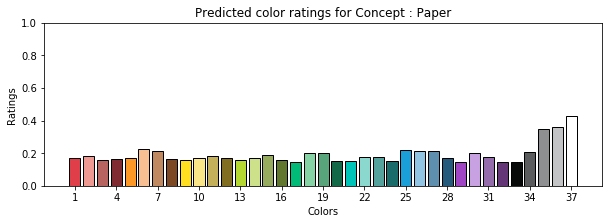

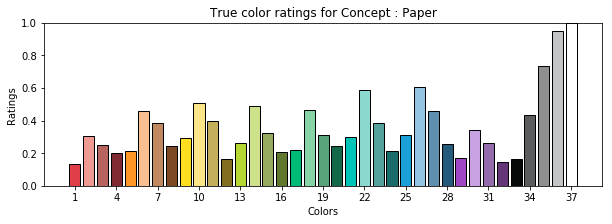

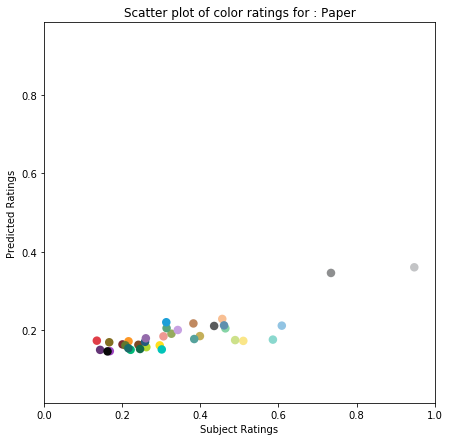

(1850,)
The true squared error (in color ratings) for left out fruit Plastic is: 1.4073

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4048
p-value 0.0130


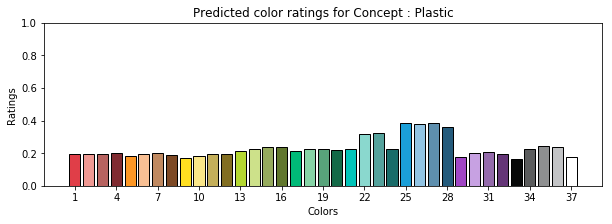

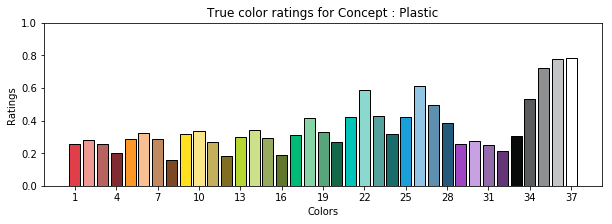

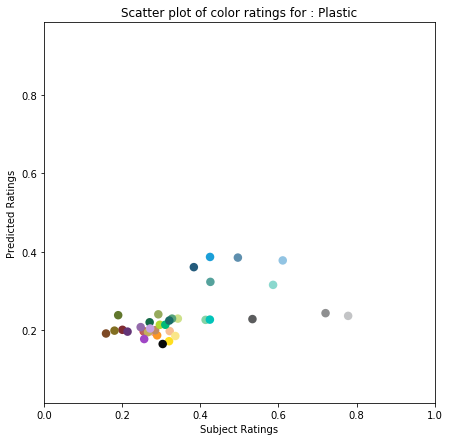

(1850,)
The true squared error (in color ratings) for left out fruit Trash is: 1.9371

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5151
p-value 0.0011


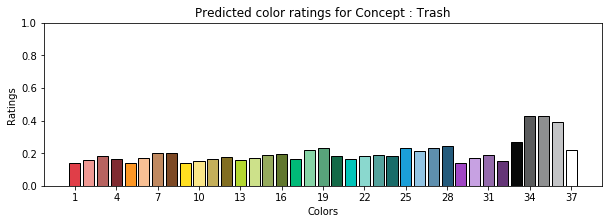

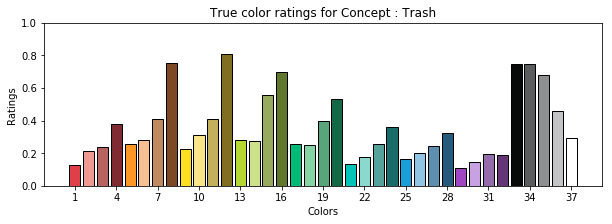

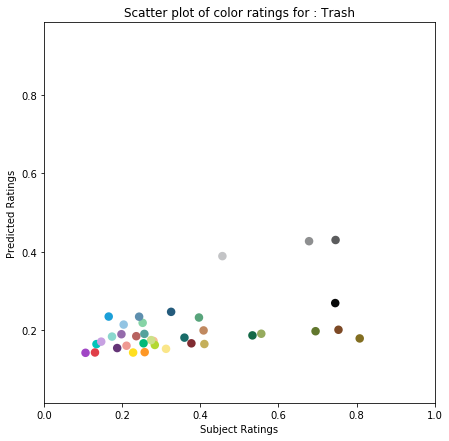

(1850,)
The true squared error (in color ratings) for left out fruit Compost is: 1.8387

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6639
p-value 0.0000


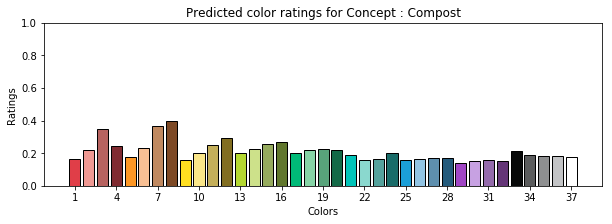

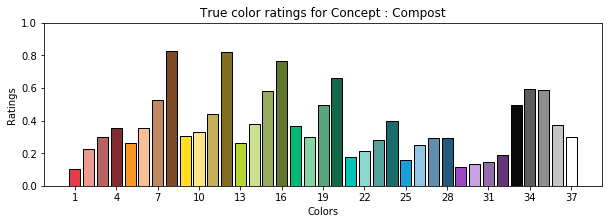

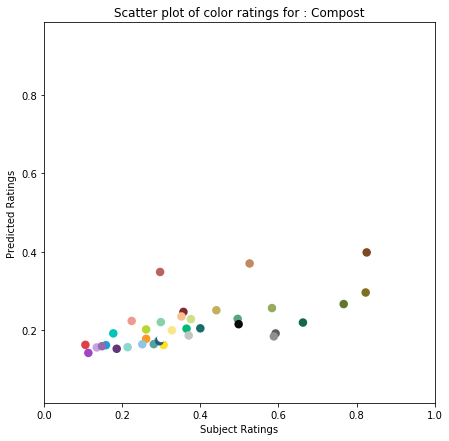

(1850,)
The true squared error (in color ratings) for left out fruit Metal is: 0.8006

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8719
p-value 0.0000


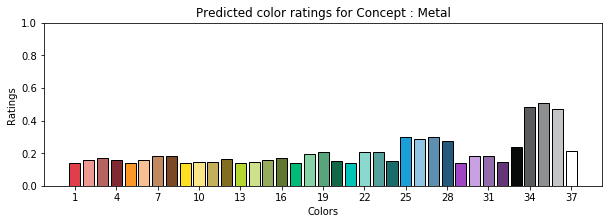

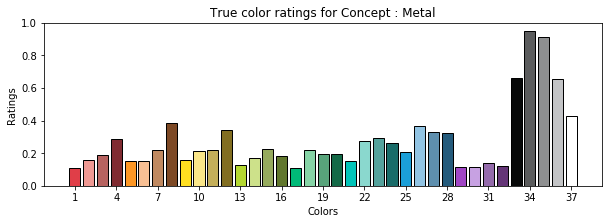

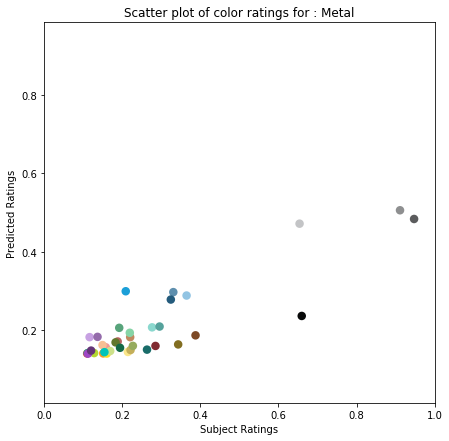

(1850,)
The true squared error (in color ratings) for left out fruit Glass is: 2.0554

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7731
p-value 0.0000


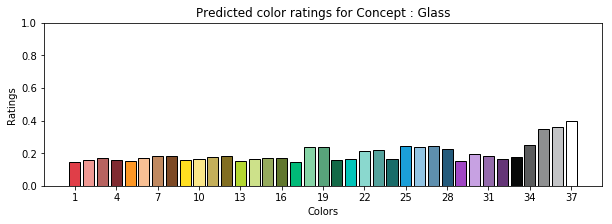

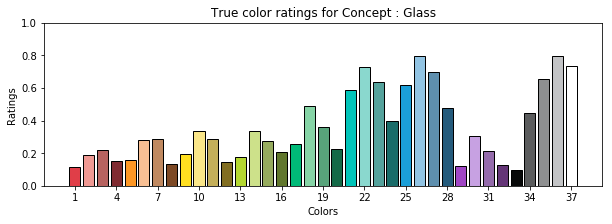

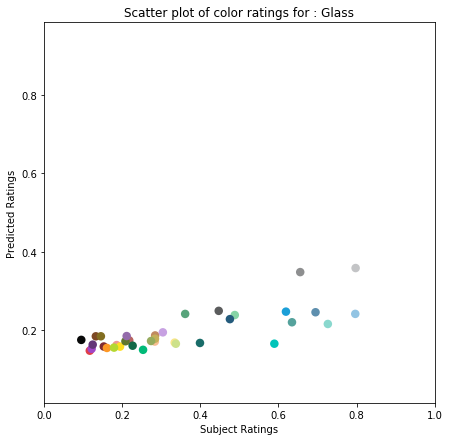

In [25]:
from scipy import stats
plt.close('all')
win0 = []
win1 = []
win2 = []

correlation = []
error = []

for i in range(len(strtInd)-1):
    # Leave one entire fruit group
    testFruit =  allConcepts[i]
    #print("\nLeaving out fruit group : ",allConcepts[i])
    y_pred = np.copy(y_predAll[strtInd[i]:strtInd[i+1]])
    y_test = np.copy(ytest[strtInd[i]:strtInd[i+1]])
    print(y_pred.shape)
    totalTestImages = y_pred.size/numColors  #37N rows -> every image has 37 rows of data
    avg_pred =[np.sum([y_pred[p] for p in range(q,y_pred.size,numColors)])/totalTestImages for q in range(numColors)]

    # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
    trueRating = np.copy(y_test[0:numColors])
    
    sqErr = np.sum(pow(avg_pred - trueRating,2))
    print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)
    
    corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
    
    print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
    print("p-value %.4f" %pVal)

    error.append(sqErr)
    correlation.append(corrCoeff)
    win0.append(corrCoeff) # saves correlation for test fruit
    win1.append(trueRating) # saves true rating for test fruit
    win2.append(avg_pred)   # saves avg predicted rating for test fruit
    # Plot average color rating over all test images.
    fig= plt.figure(figsize=(10,3))
    barPlot = plt.bar(range(1,numColors+1),avg_pred,color = colorDataRGB.values,edgeColor = [0, 0, 0])
    plt.ylabel('Ratings')
    plt.xlabel('Colors')
    plt.title('Predicted color ratings for Concept : %s' %testFruit)
    plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
    plt.ylim(0,1)
    plt.show()

    fig= plt.figure(figsize=(10,3))
    barPlot = plt.bar(range(1,numColors+1), trueRating,color = colorDataRGB.values,edgeColor = [0, 0, 0])
    plt.ylabel('Ratings')
    plt.xlabel('Colors')
    plt.title('True color ratings for Concept : %s' %testFruit)
    plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
    plt.ylim(0,1)
    plt.show()

    # Scatter plot
    fig2 = plt.figure(figsize=(7,7))
    plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
    plt.ylabel('Predicted Ratings')
    plt.xlabel('Subject Ratings')
    plt.title('Scatter plot of color ratings for : %s' %testFruit)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show() 

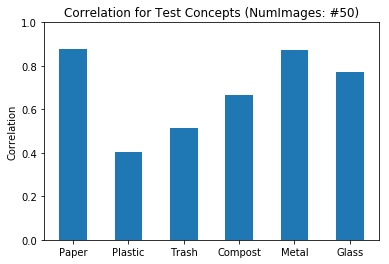

In [26]:
barWidth = 0.5
plt.bar(range(1,7),win0, width = barWidth)
plt.xticks(range(1,7),allConcepts)
plt.title("Correlation for Test Concepts (NumImages: #50)")
plt.ylabel('Correlation')
plt.ylim(0,1)
plt.show()

# Analysis using just top 5

In [27]:
numColors

37

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Paper is: 2.1064

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7748
p-value 0.0000


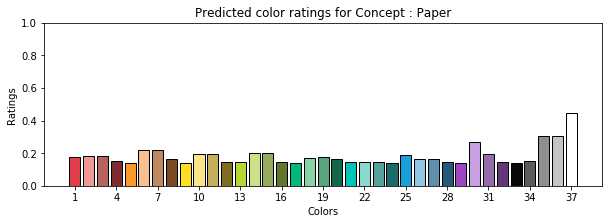

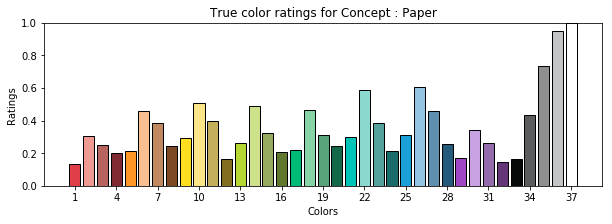

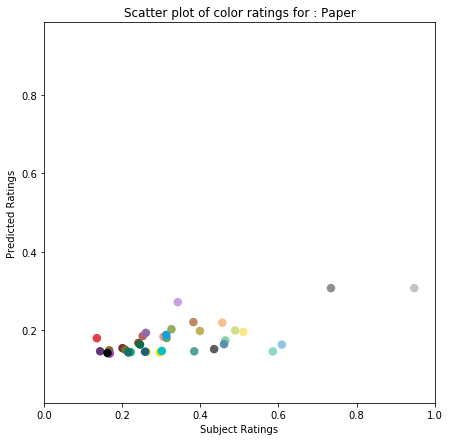

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Plastic is: 1.2363

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4704
p-value 0.0033


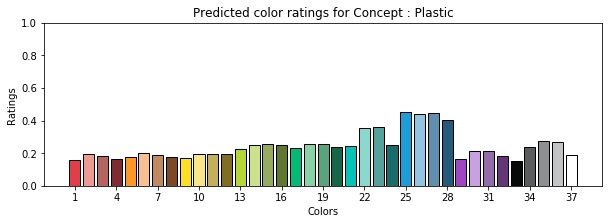

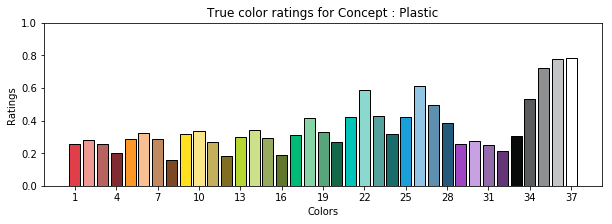

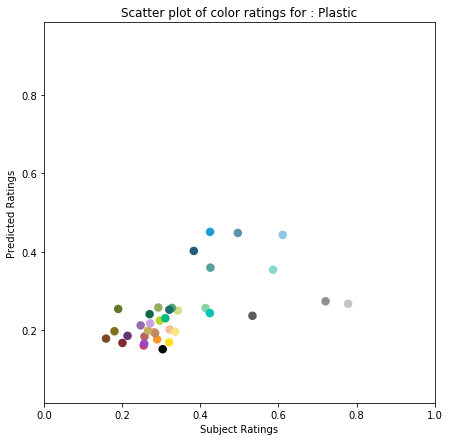

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Trash is: 2.0598

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.3528
p-value 0.0322


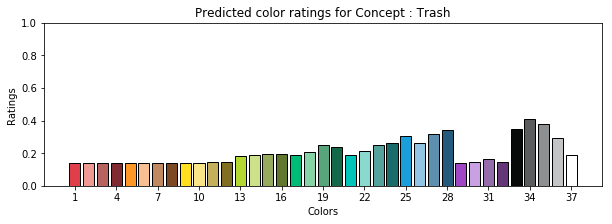

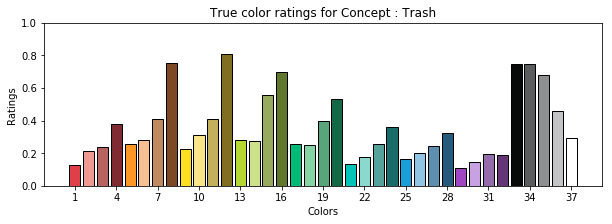

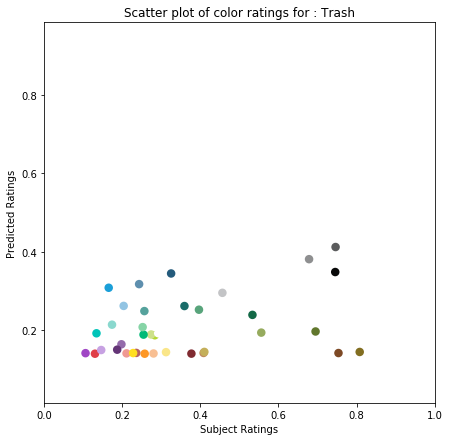

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Compost is: 1.7882

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6194
p-value 0.0000


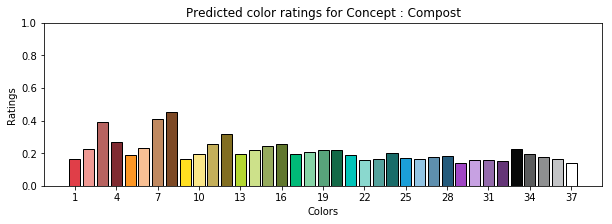

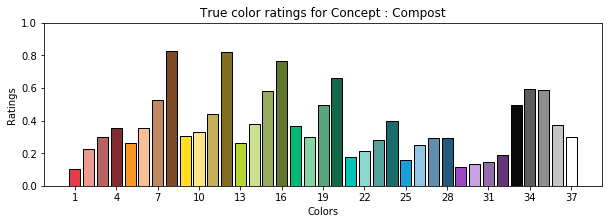

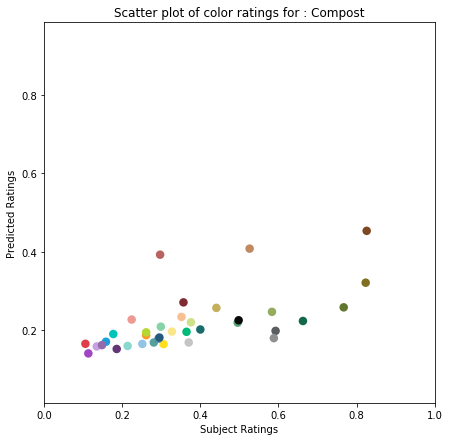

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Metal is: 1.3191

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4829
p-value 0.0025


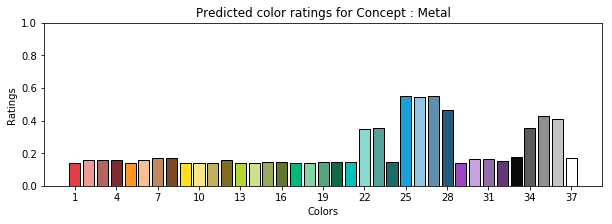

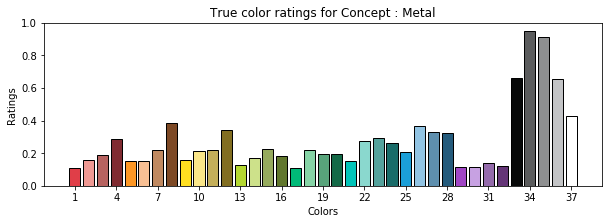

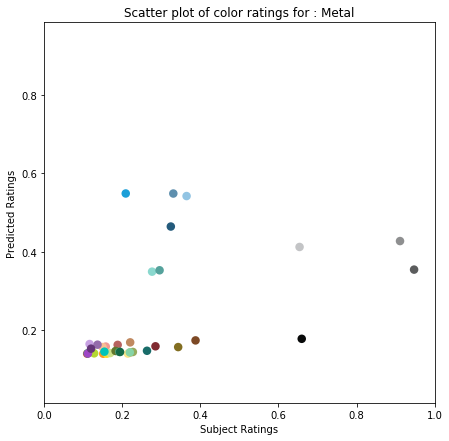

(185,)
Total test images:  5.0
The true squared error (in color ratings) for left out fruit Glass is: 2.3938

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5080
p-value 0.0013


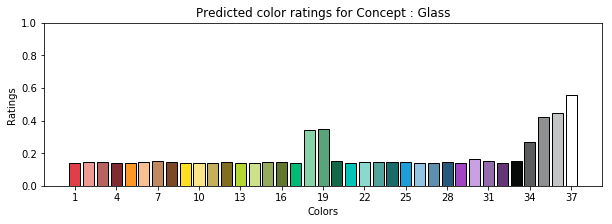

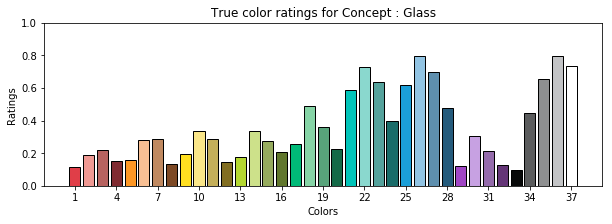

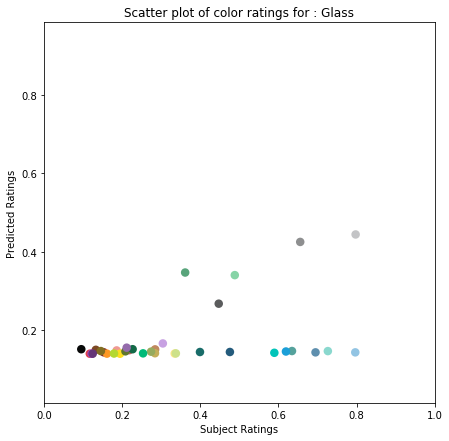

In [28]:
from scipy import stats
plt.close('all')
win0 = []
win1 = []
win2 = []

correlation = []
error = []

for i in range(len(strtInd)-1):
    # Leave one entire fruit group
    testFruit =  allConcepts[i]
    #print("\nLeaving out fruit group : ",allConcepts[i])
    y_pred = np.copy(y_predAll[strtInd[i]:strtInd[i]+(5*numColors)])
    
    y_test = np.copy(ytest[strtInd[i]:strtInd[i]+(5*numColors)])
    print(y_pred.shape)
    totalTestImages = y_pred.size/numColors  #37N rows -> every image has 37 rows of data
    print("Total test images: ",  totalTestImages)
    avg_pred = np.array([np.sum([y_pred[p] for p in range(q,y_pred.size,numColors)])/totalTestImages for q in range(numColors)])
    #print(avg_pred)
    # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
    trueRating = np.copy(y_test[0:numColors])
   
    sqErr = np.sum(pow(avg_pred - trueRating,2))
    print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)
    
    corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
    
    print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
    print("p-value %.4f" %pVal)

    error.append(sqErr)
    correlation.append(corrCoeff)
    win0.append(corrCoeff) # saves correlation for test fruit
    win1.append(trueRating) # saves true rating for test fruit
    win2.append(avg_pred)   # saves avg predicted rating for test fruit
    # Plot average color rating over all test images.
    fig= plt.figure(figsize=(10,3))
    barPlot = plt.bar(range(1,numColors+1),avg_pred,color = colorDataRGB.values,edgeColor = [0, 0, 0])
    plt.ylabel('Ratings')
    plt.xlabel('Colors')
    plt.title('Predicted color ratings for Concept : %s' %testFruit)
    plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
    plt.ylim(0,1)
    plt.show()

    fig= plt.figure(figsize=(10,3))
    barPlot = plt.bar(range(1,numColors+1), trueRating,color = colorDataRGB.values,edgeColor = [0, 0, 0])
    plt.ylabel('Ratings')
    plt.xlabel('Colors')
    plt.title('True color ratings for Concept : %s' %testFruit)
    plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
    plt.ylim(0,1)
    plt.show()

    # Scatter plot
    fig2 = plt.figure(figsize=(7,7))
    plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
    plt.ylabel('Predicted Ratings')
    plt.xlabel('Subject Ratings')
    plt.title('Scatter plot of color ratings for : %s' %testFruit)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show() 

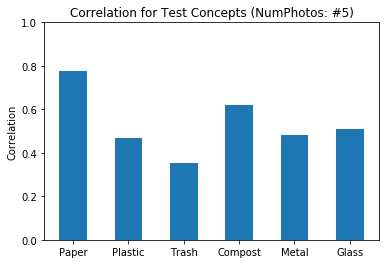

In [29]:
barWidth = 0.5
plt.bar(range(1,7),win0, width = barWidth)
plt.xticks(range(1,7),allConcepts)
plt.title("Correlation for Test Concepts (NumPhotos: #5)")
plt.ylabel('Correlation')
plt.ylim(0,1)
plt.show()